In [1]:
#https://github.com/filipradenovic/cnnimageretrieval-pytorch/blob/master/cirtorch/utils/download.py
from third_party import download


In [2]:
DATA_DIR='data/'
!mkdir $DATA_DIR

mkdir: cannot create directory ‘data/’: File exists


Since there is no labeled data, we should validate on some exsiting datasets. One possibility is to use 
https://www.kaggle.com/c/landmark-recognition-2019 data, but so far I have no HDD space to fully download it.
Moreover, it is too huge to allow fast iterating, so lets find something smaller. One possibility is to use Oxford5k and Paris6k datasets.


In [3]:
download.download_test(DATA_DIR)

>> Dataset oxford5k directory does not exist. Creating: data/test/oxford5k/jpg
>> Downloading dataset oxford5k archive oxbuild_images.tgz...
>> Extracting dataset oxford5k archive oxbuild_images.tgz...
>> Extracted, deleting dataset oxford5k archive oxbuild_images.tgz...
>> Downloading dataset oxford5k ground truth file...
>> Dataset paris6k directory does not exist. Creating: data/test/paris6k/jpg
>> Downloading dataset paris6k archive paris_1.tgz...
>> Extracting dataset paris6k archive paris_1.tgz...
>> Extracted, deleting dataset paris6k archive paris_1.tgz...
>> Downloading dataset paris6k archive paris_2.tgz...
>> Extracting dataset paris6k archive paris_2.tgz...
>> Extracted, deleting dataset paris6k archive paris_2.tgz...
>> Downloading dataset paris6k ground truth file...
>> Dataset roxford5k directory does not exist. Creating: data/test/roxford5k/jpg
>> Created symbolic link from oxford5k jpg to roxford5k jpg
>> Downloading dataset roxford5k ground truth file...
>> Dataset rp

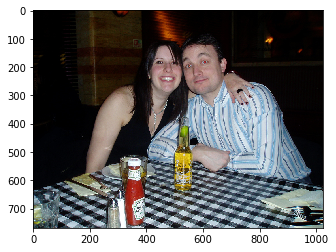

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('data/test/oxford5k/jpg/oxford_001195.jpg'))

Now, lets download SfM120k dataset (http://cmp.felk.cvut.cz/cnnimageretrieval/) - for training.

In [6]:
download.download_train(DATA_DIR)
#takes ~40 min


>> Image directory does not exist. Creating: data/train/retrieval-SfM-120k/ims
>> Downloading ims.tar.gz...
>> Extracting data/train/retrieval-SfM-120k/ims/ims.tar.gz...
>> Extracted, deleting data/train/retrieval-SfM-120k/ims/ims.tar.gz...
>> Created symbolic link from retrieval-SfM-120k/ims to retrieval-SfM-30k/ims
>> DB file retrieval-SfM-120k.pkl does not exist. Downloading...
>> DB file retrieval-SfM-120k-whiten.pkl does not exist. Downloading...
>> DB file retrieval-SfM-30k-whiten.pkl does not exist. Downloading...


SfM120k has a special structure: images of 500+ landmarks, from different sizes. There so called "query" images and pool of positive images, which 100% depicts the same side of the same landmark. Other images from the same cluster may or may not depict the same part of the landmark. Original paper https://arxiv.org/abs/1711.02512 use hard negative mining and special sampling relying on such structure.

However, https://www.kaggle.com/c/landmark-recognition-2019 dataset has different, "classification-like" structure. So we will convert SfM120k labels to the same format for simplicity. If you want to use original format, I suggest you to drop this starter and use directly https://github.com/filipradenovic/cnnimageretrieval-pytorch 

In [7]:
from third_party.datahelpers import cid2filename
import pickle

with open('data/train/retrieval-SfM-120k/retrieval-SfM-120k.pkl', 'rb') as f:
    db = pickle.load(f)['train']
    
images = [cid2filename(db['cids'][i], 'data/train/retrieval-SfM-120k/ims/') for i in range(len(db['cids']))]
clusters = db['cluster']
qpool = db['qidxs']
ppool = db['pidxs']
qpidxs = list(set([(qpool[i], ppool[i]) for i in range(len(ppool))]))

In [9]:
#Gather all "query+positive pool" into classes
invert_list = {}
subclusters = {}
subidx = 0
for q,p in qpidxs:
    #print (q,p)
    if q not in invert_list and p not in invert_list:
        subclusters[subidx] = []
        subclusters[subidx].append(p)
        subclusters[subidx].append(q)
        invert_list[p] = subidx
        invert_list[q] = subidx
        subidx+=1
    else:
        if p in invert_list:
            exist_sub_idx = invert_list[p]
            invert_list[q] = exist_sub_idx
        else:
            exist_sub_idx = invert_list[q]
            invert_list[p] = exist_sub_idx
        subclusters[exist_sub_idx].append(p)
        subclusters[exist_sub_idx].append(q)
print (len(subclusters))

23974


In [12]:
#Here we create full csv and small (for quick experimenting)
import os
count_no_class= 0
prefix = os.path.join(DATA_DIR, 'train/retrieval-SfM-120k/ims/')

with open('train_sfm120k_1000_classes.csv', 'w') as f:
    f.write('Image,cluster,Id\n')
    for i in range(len(images)):
        img = images[i].replace(prefix,'')
        if i in invert_list:
            if invert_list[i] > 1000:
                continue
            f.write(img+','+str(clusters[i])+','+str(invert_list[i])+'\n')
print (count_no_class, len(images))
with open('train_sfm120k_full.csv', 'w') as f:
    f.write('Image,cluster,Id\n')
    for i in range(len(images)):
        img = images[i].replace(prefix,'')
        if i in invert_list:
            f.write(img+','+str(clusters[i])+','+str(invert_list[i])+'\n')
        else:
            f.write(img+','+str(clusters[i])+',-1\n')
            count_no_class+=1
print (count_no_class, len(images))

0 91642
7386 91642


Now we can go to the [training-validate-submit.ipynb](training-validate-submit.ipynb) and [validate-and-submit-no-training.ipynb](validate-and-submit-no-training.ipynb) notebooks